In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = torchvision.datasets.MNIST(
    root="/data/sshadmin/bocheng/data/torchvision/mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)

Using device: cuda
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 6, 0, 8, 5, 9, 4, 6])


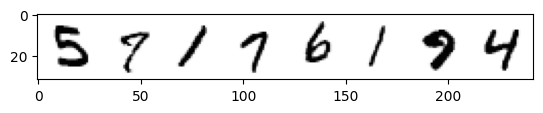

In [3]:
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [6]:
def corrupt(x,amount):
    noise=torch.rand_like(x) #噪声
    amount=amount.view(-1,1,1,1)
    return x*(1-amount)+noise*amount

torch.Size([8])
torch.Size([8, 1, 28, 28])


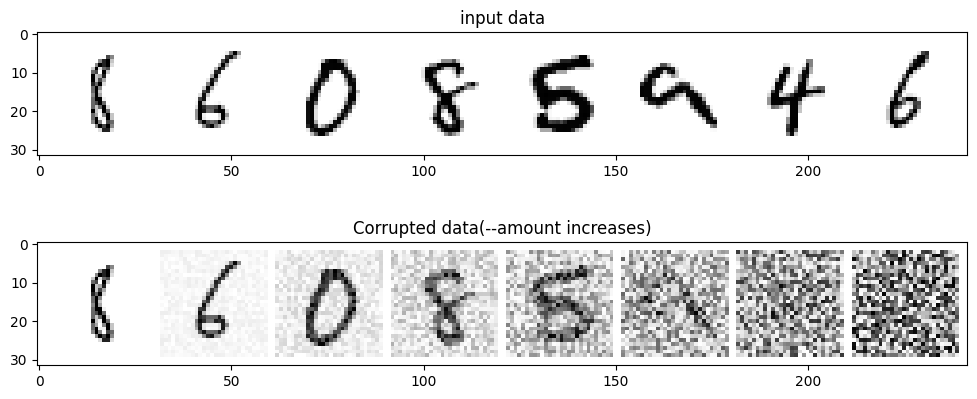

In [8]:
fig,axs=plt.subplots(2,1,figsize=(12,5))
axs[0].set_title("input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")
amount=torch.linspace(0,1,x.shape[-0])
print(amount.shape)
noised_x=corrupt(x,amount) #对输入加噪声
print(noised_x.shape)
axs[1].set_title('Corrupted data(--amount increases)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0],cmap="Greys")

In [13]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

In [14]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape
# 输出
torch.Size([8, 1, 28, 28])

torch.Size([8, 1, 28, 28])

In [15]:
sum(p.numel() for p in net.parameters())

309057

Finished epoch 0. Average loss for this epoch: 0.027205
Finished epoch 1. Average loss for this epoch: 0.020540
Finished epoch 2. Average loss for this epoch: 0.018636


(0.0, 0.1)

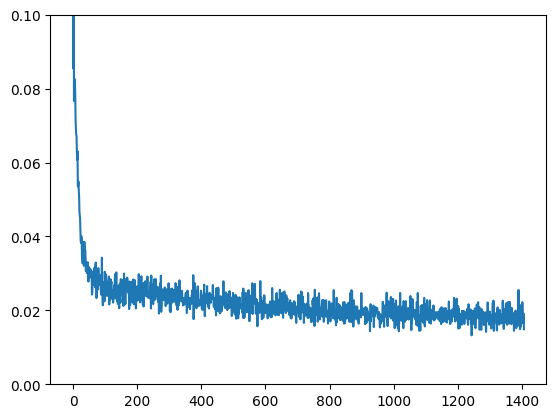

In [16]:
batch_size=128
train_dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
n_epochs=3
net=BasicUNet()
net.to(device)
loss_fn=nn.MSELoss()
opt=torch.optim.Adam(net.parameters(),lr=1e-3)
losses=[]
for epoch in range(n_epochs):
    for x,y in train_dataloader:
        x=x.to(device)
        noise_amount=torch.rand(x.shape[0]).to(device)
        noise_y=corrupt(x,noise_amount)
        pred=net(noise_y)
        loss=loss_fn(pred,x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    avg_loss=sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')
plt.plot(losses)
plt.ylim(0,0.1)


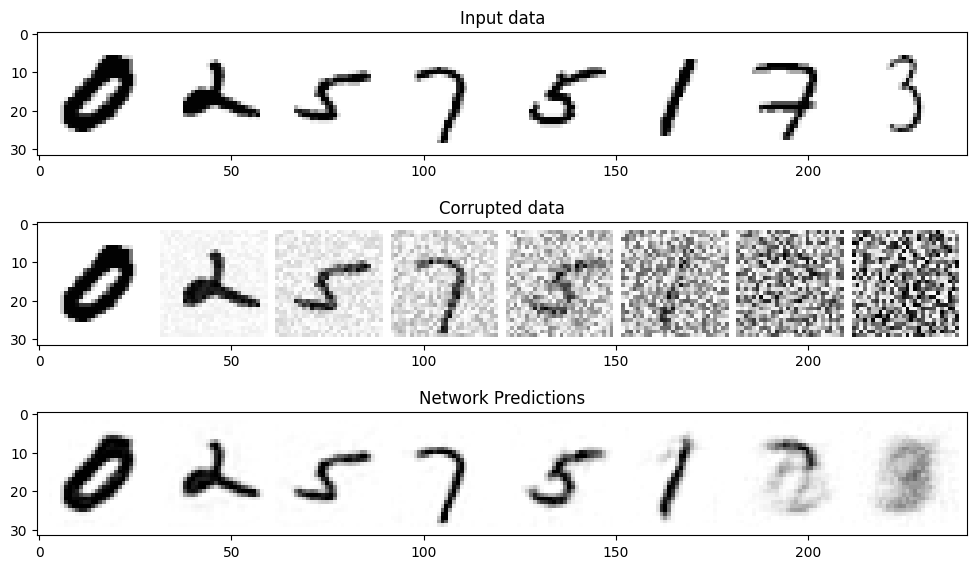

In [17]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');